## Plotting

Originally written by Alex Broughton



In [1]:
! eups list -s | grep lsst_distrib

lsst_distrib          g4213664e8e+995cec829e 	w_2023_29 setup


In [2]:
# Imports
import sys
sys.path.append('/sdf/home/a/abrought/bin')
from SpotAnalysis import *
import matplotlib.pyplot as plt
from IPython.display import display, Latex

#### Read Data

In [4]:
# Use sensor data
sensor = "R03_S12"
detector = 23

# Butler repository
outdir = "/sdf/home/a/abrought/run5/BF/data/2023-09-15/"

# Retrieve data
data_uncorrected = readData( outdir + "data_13248_R03_S12_2023-09-19T12:17:07_680nm_uncorrected.pkl", \
                             expstoremove=1)
#data_corrected = readData(   outdir + "data_13249_R03_S12_2023-03-03T14:37:51_680nm_ellipse_corrected_max100kE_noQuadFit_corrModelr_3.pkl", \
#                             expstoremove=1)




In [5]:
def cut(src, fluxCutThreshold=0.95, onlyConvergedGridFits=True):

    maxFlux = np.nanmax(src['peakSignal'])
    thresh = np.percentile(src['peakSignal'], fluxCutThreshold*100)
    #select = src['base_SdssShape_instFlux'] >= self.fluxCutThreshold*maxFlux
    select = (src['peakSignal'] >= thresh) & (src['spot_indices'] >= 0)


    #if not np.all(np.abs(src['base_SdssCentroid_y'] - src['spotgrid_y']) < 2.) or not np.all(np.abs(src['base_SdssCentroid_x'] - src['spotgrid_x']) < 2.):
    #    return []

    #mask = select
    #print("NUMPOINTS LEFT: ", len(src[mask]), "\n")

    return select

In [13]:
from astropy.table import Table




def plot_bf_slope_each_spot(data_uncorrected):
    spots_arr = []
    for exp in data_uncorrected:
        spots_arr.extend(['%04d' % n for n in exp['spot_indices']])
    
    spots_to_track = np.unique(spots_arr)
    #print(spots_to_track)
    print("Num spots to track:", len(spots_to_track))

    colnames=('spot', 'n', 'signal', 'Ixy', 'Ixx', 'Iyy', 'slope')
    datadict = dict()
    exptimes = np.zeros(len(spots_to_track))
    peakSignals = np.zeros(len(spots_to_track))
    Ixxs = np.zeros(len(spots_to_track))
    
    
    ref = dict()
    for i, spot in enumerate(spots_to_track):

        #if len(list(str(spot))) < 4:
        #    continue
    
        n = 0
        Ixy = []
        Ixx = []
        Iyy = []
        signal = []
        for j, exp in enumerate(data_uncorrected):
            #print(exp['max_bkg'])
            #exp = cut(exp)
            if len(exp) == 0:
                continue

            indices = np.asarray(['%04d' % n for n in exp['spot_indices']])
            
            if spot in indices:
                index = np.argwhere(indices == spot)
                
                if len(index.ravel()) > 1:
                    #print(spot)
                    continue
                if exp['exptime'] != 20.:
                    continue

                index = index[0]

                signal.append(exp['base_PsfFlux_instFlux'][index][0])
                Ixy.append(exp['Ixy'][index][0])
                Ixx.append(exp['Ixx'][index][0])
                Iyy.append(exp['Iyy'][index][0])
                
        ref[spot] = {'Ixy': np.asarray(Ixy),
                     'Ixx': np.asarray(Ixx),
                     'Iyy': np.asarray(Iyy),
                     'signal': np.asarray(signal)}
    

    
    for i, spot in enumerate(spots_to_track):
        #if len(list(str(spot))) < 4:
        #    continue
    
        n = 0
        exptime = []
        signal = []
        Ixy = []
        Ixx = []
        Iyy = []
        slope = 0.0
        for j, exp in enumerate(data_uncorrected):
            #exp = cut(exp)
            if len(exp) == 0:
                continue
            
            indices = np.asarray(['%04d' % n for n in exp['spot_indices']])
            
            if spot in indices:
                index = np.argwhere(indices == spot)
                
                if len(index.ravel()) > 1:
                    #print(spot)
                    continue
                if exp['exptime'] < 20.:
                    continue

                index = index[0]
                
                n = n+1
                exptime.append(exp['exptime'])
                signal.append(exp['base_PsfFlux_instFlux'][index][0])
                #print(i, spot, j, index, exp['Ixx'][index][0], exp['Iyy'][index][0])
                
                Ixy.append(exp['Ixy'][index][0])
                Ixx.append(exp['Ixx'][index][0])
                Iyy.append(exp['Iyy'][index][0])
        
        if n >= 10:
            #print(np.asarray(signal))
            (slopeT , _), C_T = np.polyfit(np.asarray(signal), np.asarray(Ixx) + np.asarray(Iyy) - np.mean(ref[spot]['Ixx'] + ref[spot]['Iyy']), 1, cov=True)
            (slopexy , _), C_xy = np.polyfit(np.asarray(signal), np.asarray(Ixy) - np.mean(ref[spot]['Ixy']), 1, cov=True)
            (slopexx , _), C_xx = np.polyfit(np.asarray(signal), np.asarray(Ixx) - np.mean(ref[spot]['Ixx']), 1, cov=True)
            (slopeyy , _), C_yy = np.polyfit(np.asarray(signal), np.asarray(Iyy) - np.mean(ref[spot]['Iyy']), 1, cov=True)
            
            datadict[spot] = {'n' : n,
                              'exptime' : exptime,
                              'signal' : np.asarray(signal),
                              'Ixy' : np.asarray(Ixy),
                              'Ixx' : np.asarray(Ixx),
                              'Iyy' : np.asarray(Iyy),
                              'slope-T' : slopeT,
                              'slope-T-err' : C_T[0][0],
                              'slope-ixy' : slopexy,
                              'slope-ixy-err' : C_xy[0][0],
                              'slope-ixx' : slopexx,
                              'slope-ixx-err' : C_xx[0][0],
                              'slope-iyy' : slopeyy,
                              'slope-iyy-err' : C_yy[0][0]}
            
            #print(spot, datadict[str(spot)])
            #t.add_row((spot, n, [], [np.asarray(Ixx)], [np.asarray(Iyy)], slope))
        
    return datadict, ref, spots_to_track



In [14]:
t, ref, spots_to_track = plot_bf_slope_each_spot(data_uncorrected)



Num spots to track: 217


## All Spots

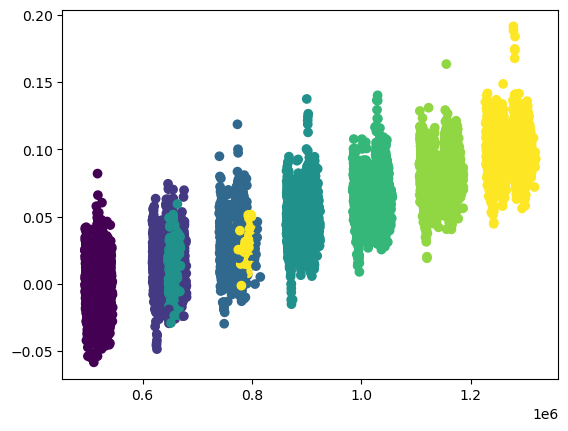

In [15]:
for i, spot in enumerate(spots_to_track):
    try:
        plt.scatter(t[spot]['signal'], t[spot]['Ixx'] - np.mean(ref[spot]['Ixx']), c=t[spot]['exptime'])
    except:
        continue
    #plt.ylim(9.35,9.7)
    #plt.xlim(30000,100000)
    

## Single Spot

(30000.0, 100000.0)

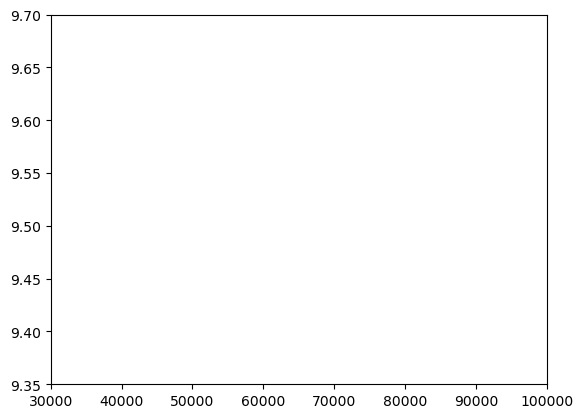

In [16]:
num = 1202
plt.scatter(t[str(num)]['signal'], t[str(num)]['Ixx'])
plt.ylim(9.35,9.7)
plt.xlim(30000,100000)

## Fitting Function

(Astier+23 notation)
## $I_{\mu\nu} - I_{\mu\nu,15s} = \alpha_{\mu\nu}f_{max} + \gamma$


# R03-S12
_____________________

## BF Uncorrected

3.0823227431862895e-15


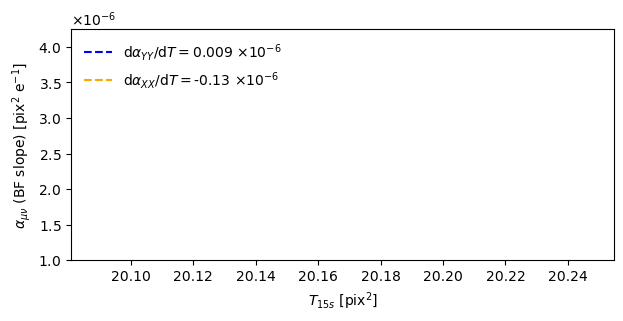

In [17]:
x = []
y = []
x2 = []
y2 = []
plt.figure(figsize=(7,3))
for count, key in enumerate(t):
    #print(t[key]['exptime'])
    inds = np.argwhere(np.asarray(t[key]['exptime']) == 20.0)
    if len(inds) == 0:
        continue
    if t[key]['slope-ixx']*100*10000 > 3.:
        continue
    x.append(np.mean(t[key]['Ixx'][inds])+np.mean(t[key]['Iyy'][inds]))
    y.append(t[key]['slope-ixx'])
    x2.append(np.mean(t[key]['Ixx'][inds])+np.mean(t[key]['Iyy'][inds]))
    y2.append(t[key]['slope-iyy'])
    plt.scatter(np.mean(t[key]['Ixx'][inds])+np.mean(t[key]['Iyy'][inds]),t[key]['slope-iyy'], s=5, color="b")
    plt.scatter(np.mean(t[key]['Ixx'][inds])+np.mean(t[key]['Iyy'][inds]),t[key]['slope-ixx'], s=5, color="orange")
    #plt.scatter(,t[key]['slope']*100*10000, color="b")

(m,b), C = np.polyfit(x, y, 1, cov=True)
(m2,b2), C2 = np.polyfit(x2, y2, 1, cov=True)
print(C2[0][0])
m_prime = str(round(m * 1e6, 3))
m2_prime = str(round(m2 * 1e6, 3))
plt.plot(np.linspace(np.min(x2), np.max(x2), 100), m2 * np.linspace(np.min(x2), np.max(x2), 100) + b2, linestyle="--", color='blue', label=r"$\mathrm{d}\alpha_{YY} / \mathrm{d}T = $" + m2_prime + r" $\times 10^{-6}$")
plt.plot(np.linspace(np.min(x), np.max(x), 100), m * np.linspace(np.min(x), np.max(x), 100) + b, linestyle="--", color='orange', label=r"$\mathrm{d}\alpha_{XX} / \mathrm{d}T = $" + m_prime + r" $\times 10^{-6}$")


plt.ylabel(r"$\alpha_{\mu\nu}$ (BF slope) [pix$^{2}$ e$^{-1}$]")
plt.xlabel("$T_{15s}$ [pix$^2$]")
#plt.xlim(19.96, 20.13)
plt.ylim(1.0e-6,4.25e-6)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0), useMathText=True)
_ = plt.legend(loc=2, frameon=False)

In [18]:
import matplotlib
matplotlib.rcParams.update({'font.size': 15})

-2.568886077236268e-07 2.588833244266007e-06 7.396993637364916e-08
err_prime 0.07
3.904866054112518e-08
1.2859657645675806e-07
0.3036524114174664


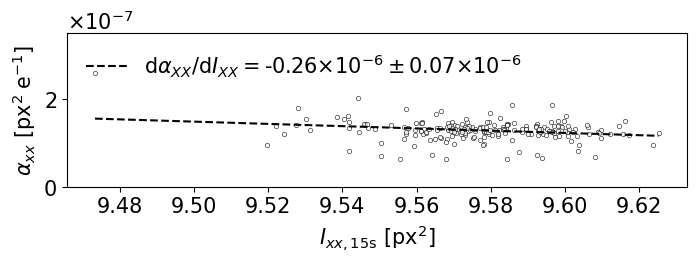

In [24]:
x = []
y = []
#x2 = []
#y2 = []
plt.figure(figsize=(8,2))
for count, key in enumerate(t):
    #print(t[key]['exptime'])
    inds = np.argwhere(np.asarray(t[key]['exptime']) == 20.0)
    if len(inds) == 0:
        continue
    if t[key]['slope-ixx']*100*10000 > 3.:
        continue
    
    x.append(np.mean(t[key]['Ixx'][inds]))
    y.append(t[key]['slope-ixx'])
    #x2.append(np.mean(t[key]['Iyy'][inds]))
    #y2.append(t[key]['slope-iyy'])
    #plt.scatter(np.mean(ref[key]['Iyy']),t[key]['slope-iyy'], s=5, color="b")
    plt.scatter(np.mean(ref[key]['Ixx']),t[key]['slope-ixx'], s=10, color="k", marker='o', facecolor='w', linewidths=0.5, alpha=0.75)
    #plt.scatter(,t[key]['slope']*100*10000, color="b")

(m,b), cov = np.polyfit(x, y, 1, cov=True)
print(m,b, np.sqrt(cov[0][0]))
#m2,b2 = np.polyfit(x2, y2, 1)
m_prime = str(round(m * 1e6, 2))
#m2_prime = str(round(m2 * 1e6, 3))

err_prime = str(round(np.sqrt(cov[0][0]) * 1e6, 2))
print("err_prime", err_prime)
#plt.plot(np.linspace(np.min(x2), np.max(x2), 100), m2 * np.linspace(np.min(x2), np.max(x2), 100) + b2, linestyle="--", color='blue', label=r"$\mathrm{d}\alpha_{YY} / \mathrm{d}I_{YY} = $" + m2_prime + r" $\times 10^{-6}$")
plt.plot(np.linspace(np.min(x), np.max(x), 100), m * np.linspace(np.min(x), np.max(x), 100) + b, linestyle="--", color='k', label=r"$\mathrm{d}\alpha_{XX} / \mathrm{d}I_{XX} = $" + m_prime + r"$\times 10^{-6} \pm $" + err_prime + r'$\times 10^{-6}$')


plt.ylabel(r"$\alpha_{xx}$ [$\mathrm{px}^{2}\;\mathrm{e}^{-1}$]")
plt.xlabel(r"$I_{xx,15\mathrm{s}}$ [$\mathrm{px}^2$]")
#plt.xlim(19.96, 20.13)
plt.ylim(0,.35e-6)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0), useMathText=True)
_ = plt.legend(loc=2, frameon=False)
plt.savefig("../plots/BR-Ixx-R03-S12.png", bbox_inches='tight')

print(m*np.min(x) + b - (m*np.max(x) +b))
print(m*np.mean(x) + b)
print((m*np.min(x) + b - (m*np.max(x) +b)) / (m*np.mean(x) + b))

-4.126293578631526e-07 6.488406965417626e-06 1.4497090041533849e-06
3.881237468166898e-08
2.114038307550079e-06
0.018359352592171304


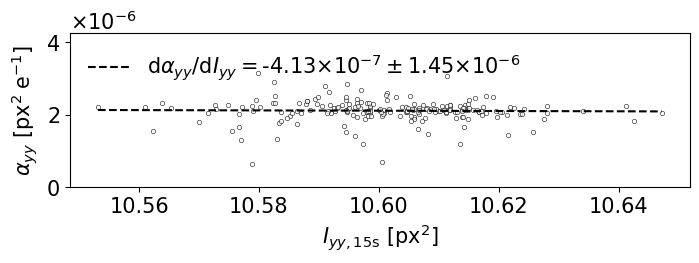

In [17]:
x = []
y = []
#x2 = []
#y2 = []
plt.figure(figsize=(8,2))
for count, key in enumerate(t):
    #print(t[key]['exptime'])
    inds = np.argwhere(np.asarray(t[key]['exptime']) == 20.0)
    if len(inds) == 0:
        continue
    if t[key]['slope-ixx']*100*10000 > 3.:
        continue
    
    x.append(np.mean(t[key]['Iyy'][inds]))
    y.append(t[key]['slope-iyy'])
    #x2.append(np.mean(t[key]['Iyy'][inds]))
    #y2.append(t[key]['slope-iyy'])
    #plt.scatter(np.mean(ref[key]['Iyy']),t[key]['slope-iyy'], s=5, color="b")
    plt.scatter(np.mean(ref[key]['Iyy']),t[key]['slope-iyy'], s=10, color="k", marker='o', facecolor='w', linewidths=0.5, alpha=0.75)
    #plt.scatter(,t[key]['slope']*100*10000, color="b")

(m,b), cov = np.polyfit(x, y, 1, cov=True)
print(m,b, np.sqrt(cov[0][0]))
#m2,b2 = np.polyfit(x2, y2, 1)
m_prime = str(round(m * 1e7, 2))
#m2_prime = str(round(m2 * 1e6, 3))

err_prime = str(round(np.sqrt(cov[0][0]) * 1e6, 2))
#plt.plot(np.linspace(np.min(x2), np.max(x2), 100), m2 * np.linspace(np.min(x2), np.max(x2), 100) + b2, linestyle="--", color='blue', label=r"$\mathrm{d}\alpha_{YY} / \mathrm{d}I_{YY} = $" + m2_prime + r" $\times 10^{-6}$")
plt.plot(np.linspace(np.min(x), np.max(x), 100), m * np.linspace(np.min(x), np.max(x), 100) + b, linestyle="--", color='k', label=r"$\mathrm{d}\alpha_{yy} / \mathrm{d}I_{yy} = $" + m_prime + r"$\times 10^{-7} \pm $" + err_prime + r'$\times 10^{-6}$')


plt.ylabel(r"$\alpha_{yy}$ [$\mathrm{px}^{2}\;\mathrm{e}^{-1}$]")
plt.xlabel(r"$I_{yy,15\mathrm{s}}$ [$\mathrm{px}^2$]")
#plt.xlim(19.96, 20.13)
plt.ylim(0,4.25e-6)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0), useMathText=True)
_ = plt.legend(loc=2, frameon=False)
plt.savefig("../plots/BR-Iyy-R03-S12.png", bbox_inches='tight')
print(m*np.min(x) + b - (m*np.max(x) +b))
print(m*np.mean(x) + b)
print((m*np.min(x) + b - (m*np.max(x) +b)) / (m*np.mean(x) + b))

-5.276101903104745e-06 3.0600108001654972e-06 1.546562638378872e-06
3.02224147277177e-07
5.845751424617e-08
5.169979448740895


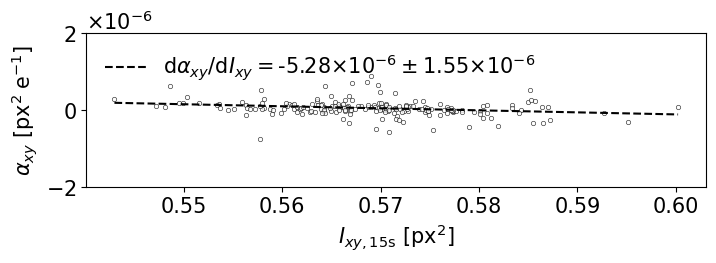

In [13]:
x = []
y = []
#x2 = []
#y2 = []
plt.figure(figsize=(8,2))
for count, key in enumerate(t):
    #print(t[key]['exptime'])
    inds = np.argwhere(np.asarray(t[key]['exptime']) == 20.0)
    if len(inds) == 0:
        continue
    if t[key]['slope-ixx']*100*10000 > 3.:
        continue
    
    x.append(np.mean(t[key]['Ixy'][inds]))
    y.append(t[key]['slope-ixy'])
    #x2.append(np.mean(t[key]['Iyy'][inds]))
    #y2.append(t[key]['slope-iyy'])
    #plt.scatter(np.mean(ref[key]['Iyy']),t[key]['slope-iyy'], s=5, color="b")
    plt.scatter(np.mean(ref[key]['Ixy']),t[key]['slope-ixy'], s=10, color="k", marker='o', facecolor='w', linewidths=0.5, alpha=0.75)
    #plt.scatter(,t[key]['slope']*100*10000, color="b")

(m,b), cov = np.polyfit(x, y, 1, cov=True)
print(m,b, np.sqrt(cov[0][0]))
#m2,b2 = np.polyfit(x2, y2, 1)
m_prime = str(round(m * 1e6, 2))
#m2_prime = str(round(m2 * 1e6, 3))

err_prime = str(round(np.sqrt(cov[0][0]) * 1e6, 2))
#plt.plot(np.linspace(np.min(x2), np.max(x2), 100), m2 * np.linspace(np.min(x2), np.max(x2), 100) + b2, linestyle="--", color='blue', label=r"$\mathrm{d}\alpha_{YY} / \mathrm{d}I_{YY} = $" + m2_prime + r" $\times 10^{-6}$")
plt.plot(np.linspace(np.min(x), np.max(x), 100), m * np.linspace(np.min(x), np.max(x), 100) + b, linestyle="--", color='k', label=r"$\mathrm{d}\alpha_{xy} / \mathrm{d}I_{xy} = $" + m_prime + r"$\times 10^{-6} \pm $" + err_prime + r'$\times 10^{-6}$')


plt.ylabel(r"$\alpha_{xy}$ [$\mathrm{px}^{2}\;\mathrm{e}^{-1}$]")
plt.xlabel(r"$I_{xy,15\mathrm{s}}$ [$\mathrm{px}^2$]")
#plt.xlim(19.96, 20.13)
plt.ylim(-2e-6,2e-6)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0), useMathText=True)
_ = plt.legend(loc=2, frameon=False)
plt.savefig("../plots/BR-Ixy-R03-S12.png", bbox_inches='tight')
print(m*np.min(x) + b - (m*np.max(x) +b))
print(m*np.mean(x) + b)
print((m*np.min(x) + b - (m*np.max(x) +b)) / (m*np.mean(x) + b))

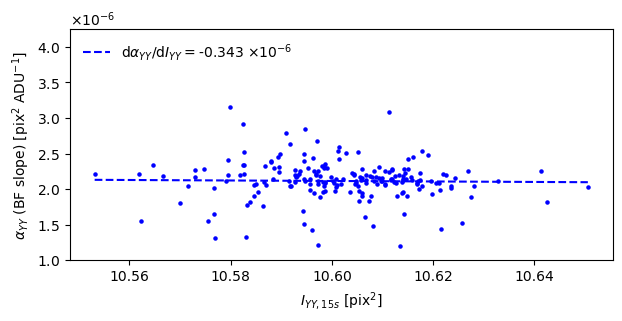

In [13]:
#x = []
#y = []
x2 = []
y2 = []
plt.figure(figsize=(7,3))
for count, key in enumerate(t):
    #print(t[key]['exptime'])
    inds = np.argwhere(np.asarray(t[key]['exptime']) == 20.0)
    if len(inds) == 0:
        continue
    if t[key]['slope-ixx']*100*10000 > 3.:
        continue
    
    #x.append(np.mean(t[key]['Ixx'][inds]))
    #y.append(t[key]['slope-ixx'])
    x2.append(np.mean(t[key]['Iyy'][inds]))
    y2.append(t[key]['slope-iyy'])
    plt.scatter(np.mean(ref[key]['Iyy']),t[key]['slope-iyy'], s=5, color="b")
    #plt.scatter(np.mean(ref[key]['Ixx']),t[key]['slope-ixx'], s=5, color="b")
    #plt.scatter(,t[key]['slope']*100*10000, color="b")

#m,b = np.polyfit(x, y, 1)
m2,b2 = np.polyfit(x2, y2, 1)
#m_prime = str(round(m * 1e6, 3))
m2_prime = str(round(m2 * 1e6, 3))
plt.plot(np.linspace(np.min(x2), np.max(x2), 100), m2 * np.linspace(np.min(x2), np.max(x2), 100) + b2, linestyle="--", color='blue', label=r"$\mathrm{d}\alpha_{YY} / \mathrm{d}I_{YY} = $" + m2_prime + r" $\times 10^{-6}$")
#plt.plot(np.linspace(np.min(x), np.max(x), 100), m * np.linspace(np.min(x), np.max(x), 100) + b, linestyle="--", color='blue', label=r"$\mathrm{d}\alpha_{XX} / \mathrm{d}I_{XX} = $" + m_prime + r" $\times 10^{-6}$")


plt.ylabel(r"$\alpha_{YY}$ (BF slope) [pix$^{2}$ e$^{-1}$]")
plt.xlabel(r"$I_{YY,15s}$ [pix$^2$]")
#plt.xlim(19.96, 20.13)
plt.ylim(1.0e-6,4.25e-6)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0), useMathText=True)
_ = plt.legend(loc=2, frameon=False)

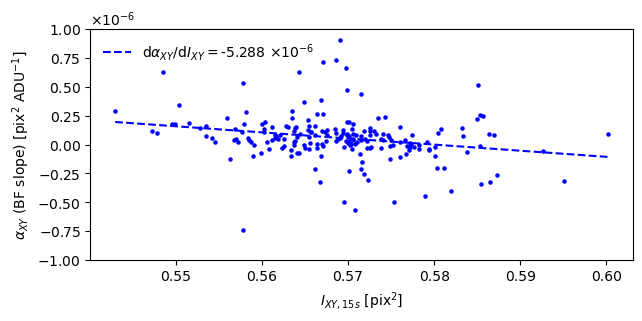

In [14]:
x = []
y = []
#x2 = []
#y2 = []
plt.figure(figsize=(7,3))
for count, key in enumerate(t):
    #print(t[key]['exptime'])
    inds = np.argwhere(np.asarray(t[key]['exptime']) == 20.0)
    if len(inds) == 0:
        continue
    if t[key]['slope-ixx']*100*10000 > 3.:
        continue
    
    x.append(np.mean(t[key]['Ixy'][inds]))
    y.append(t[key]['slope-ixy'])
    #x2.append(np.mean(t[key]['Iyy'][inds]))
    #y2.append(t[key]['slope-iyy'])
    #plt.scatter(np.mean(ref[key]['Iyy']),t[key]['slope-iyy'], s=5, color="b")
    plt.scatter(np.mean(ref[key]['Ixy']),t[key]['slope-ixy'], s=5, color="b")
    #plt.scatter(,t[key]['slope']*100*10000, color="b")

m,b = np.polyfit(x, y, 1)
#m2,b2 = np.polyfit(x2, y2, 1)
m_prime = str(round(m * 1e6, 3))
#m2_prime = str(round(m2 * 1e6, 3))
#plt.plot(np.linspace(np.min(x2), np.max(x2), 100), m2 * np.linspace(np.min(x2), np.max(x2), 100) + b2, linestyle="--", color='blue', label=r"$\mathrm{d}\alpha_{YY} / \mathrm{d}I_{YY} = $" + m2_prime + r" $\times 10^{-6}$")
plt.plot(np.linspace(np.min(x), np.max(x), 100), m * np.linspace(np.min(x), np.max(x), 100) + b, linestyle="--", color='blue', label=r"$\mathrm{d}\alpha_{XY} / \mathrm{d}I_{XY} = $" + m_prime + r" $\times 10^{-6}$")


plt.ylabel(r"$\alpha_{XY}$ (BF slope) [pix$^{2}$ e$^{-1}$]")
plt.xlabel(r"$I_{XY,15s}$ [pix$^2$]")
#plt.xlim(19.96, 20.13)
plt.ylim(-1.0e-6,1.0e-6)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0), useMathText=True)
_ = plt.legend(loc=2, frameon=False)

## BF Corrected

In [13]:
# Use sensor data
sensor = "R03_S12"
detector = 23

# Butler repository
outdir = "/home/a/abrought/run5/BF/data/2023-01-26/"

# Retrieve data
data_corrected = readData( outdir + "data_13248_R03_S12_2023-02-23T11:19:56_680nm_corrected_max100kE_noQuadFit_corrModelr_3.pkl", \
                             expstoremove=1)
#data_corrected = readData(   outdir + "data_13249_R03_S12_2023-03-03T14:37:51_680nm_ellipse_corrected_max100kE_noQuadFit_corrModelr_3.pkl", \
#                             expstoremove=1)




Removing SEQNUMs: 
221 21 321 121 

File 1
5.0s, 32 images
10.0s, 38 images
15.0s, 40 images
20.0s, 39 images
25.0s, 40 images
30.0s, 40 images
35.0s, 39 images
40.0s, 40 images
45.0s, 40 images
50.0s, 36 images


 384


In [14]:
t, ref, spots_to_track = plot_bf_slope_each_spot(data_corrected)

Num spots to track: 219


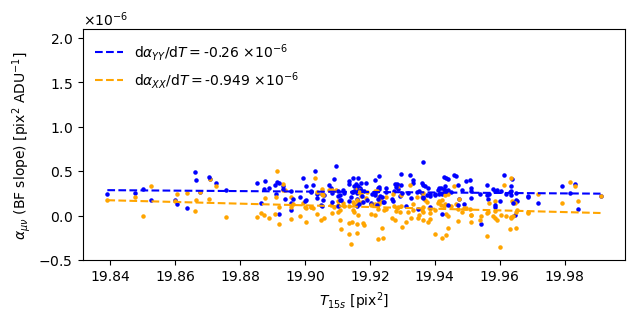

In [15]:
x = []
y = []
x2 = []
y2 = []
plt.figure(figsize=(7,3))
for count, key in enumerate(t):
    #print(t[key]['exptime'])
    inds = np.argwhere(np.asarray(t[key]['exptime']) == 20.0)
    if len(inds) == 0:
        continue
    if t[key]['slope-ixx']*100*10000 > 1.:
        continue
    x.append(np.mean(t[key]['Ixx'][inds])+np.mean(t[key]['Iyy'][inds]))
    y.append(t[key]['slope-ixx'])
    x2.append(np.mean(t[key]['Ixx'][inds])+np.mean(t[key]['Iyy'][inds]))
    y2.append(t[key]['slope-iyy'])
    plt.scatter(np.mean(t[key]['Ixx'][inds])+np.mean(t[key]['Iyy'][inds]),t[key]['slope-iyy'], s=5, color="b")
    plt.scatter(np.mean(t[key]['Ixx'][inds])+np.mean(t[key]['Iyy'][inds]),t[key]['slope-ixx'], s=5, color="orange")
    #plt.scatter(,t[key]['slope']*100*10000, color="b")

m,b = np.polyfit(x, y, 1)
m2,b2 = np.polyfit(x2, y2, 1)
m_prime = str(round(m * 1e6, 3))
m2_prime = str(round(m2 * 1e6, 3))
plt.plot(np.linspace(np.min(x2), np.max(x2), 100), m2 * np.linspace(np.min(x2), np.max(x2), 100) + b2, linestyle="--", color='blue', label=r"$\mathrm{d}\alpha_{YY} / \mathrm{d}T = $" + m2_prime + r" $\times 10^{-6}$")
plt.plot(np.linspace(np.min(x), np.max(x), 100), m * np.linspace(np.min(x), np.max(x), 100) + b, linestyle="--", color='orange', label=r"$\mathrm{d}\alpha_{XX} / \mathrm{d}T = $" + m_prime + r" $\times 10^{-6}$")


plt.ylabel(r"$\alpha_{\mu\nu}$ (BF slope) [pix$^{2}$ e$^{-1}$]")
plt.xlabel("$T_{15s}$ [pix$^2$]")
#plt.xlim(19.96, 20.13)
plt.ylim(-0.5e-6,2.1e-6)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0), useMathText=True)
_ = plt.legend(loc=2, frameon=False)

In [19]:
x = []
y = []
#x2 = []
#y2 = []
plt.figure(figsize=(7,3))
for count, key in enumerate(t):
    #print(t[key]['exptime'])
    inds = np.argwhere(np.asarray(t[key]['exptime']) == 20.0)
    if len(inds) == 0:
        continue
    if t[key]['slope-ixx']*100*10000 > 1.:
        continue
    
    x.append(np.mean(t[key]['Ixx'][inds]))
    y.append(t[key]['slope-ixx'])
    #x2.append(np.mean(t[key]['Iyy'][inds]))
    #y2.append(t[key]['slope-iyy'])
    #plt.scatter(np.mean(ref[key]['Iyy']),t[key]['slope-iyy'], s=5, color="b")
    plt.scatter(np.mean(ref[key]['Ixx']),t[key]['slope-ixx'], s=5, color="b")
    #plt.scatter(,t[key]['slope']*100*10000, color="b")

m,b = np.polyfit(x, y, 1)
#m2,b2 = np.polyfit(x2, y2, 1)
m_prime = str(round(m * 1e6, 3))
#m2_prime = str(round(m2 * 1e6, 3))
#plt.plot(np.linspace(np.min(x2), np.max(x2), 100), m2 * np.linspace(np.min(x2), np.max(x2), 100) + b2, linestyle="--", color='blue', label=r"$\mathrm{d}\alpha_{YY} / \mathrm{d}I_{YY} = $" + m2_prime + r" $\times 10^{-6}$")
plt.plot(np.linspace(np.min(x), np.max(x), 100), m * np.linspace(np.min(x), np.max(x), 100) + b, linestyle="--", color='blue', label=r"$\mathrm{d}\alpha_{XX} / \mathrm{d}I_{XX} = $" + m_prime + r" $\times 10^{-6}$")


plt.ylabel(r"$\alpha_{XX}$ (BF slope) [pix$^{2}$ e$^{-1}$]")
plt.xlabel(r"$I_{XX,15s}$ [pix$^2$]")
#plt.xlim(19.96, 20.13)
#plt.ylim(1.0e-6,4.25e-6)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0), useMathText=True)
_ = plt.legend(loc=2, frameon=False)

TypeError: expected non-empty vector for x

<Figure size 700x300 with 0 Axes>

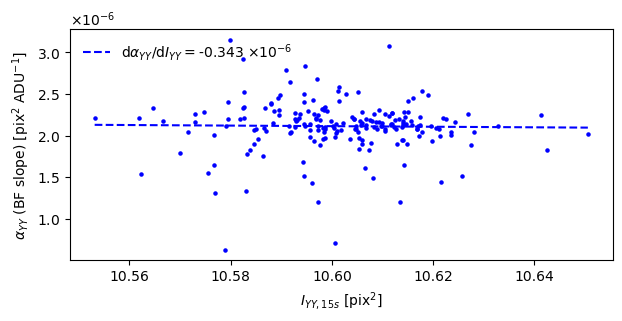

In [15]:
#x = []
#y = []
x2 = []
y2 = []
plt.figure(figsize=(7,3))
for count, key in enumerate(t):
    #print(t[key]['exptime'])
    inds = np.argwhere(np.asarray(t[key]['exptime']) == 20.0)
    if len(inds) == 0:
        continue
    if t[key]['slope-ixx']*100*10000 > 3.:
        continue
    
    #x.append(np.mean(t[key]['Ixx'][inds]))
    #y.append(t[key]['slope-ixx'])
    x2.append(np.mean(t[key]['Iyy'][inds]))
    y2.append(t[key]['slope-iyy'])
    plt.scatter(np.mean(ref[key]['Iyy']),t[key]['slope-iyy'], s=5, color="b")
    #plt.scatter(np.mean(ref[key]['Ixx']),t[key]['slope-ixx'], s=5, color="b")
    #plt.scatter(,t[key]['slope']*100*10000, color="b")

#m,b = np.polyfit(x, y, 1)
m2,b2 = np.polyfit(x2, y2, 1)
#m_prime = str(round(m * 1e6, 3))
m2_prime = str(round(m2 * 1e6, 3))
plt.plot(np.linspace(np.min(x2), np.max(x2), 100), m2 * np.linspace(np.min(x2), np.max(x2), 100) + b2, linestyle="--", color='blue', label=r"$\mathrm{d}\alpha_{YY} / \mathrm{d}I_{YY} = $" + m2_prime + r" $\times 10^{-6}$")
#plt.plot(np.linspace(np.min(x), np.max(x), 100), m * np.linspace(np.min(x), np.max(x), 100) + b, linestyle="--", color='blue', label=r"$\mathrm{d}\alpha_{XX} / \mathrm{d}I_{XX} = $" + m_prime + r" $\times 10^{-6}$")


plt.ylabel(r"$\alpha_{YY}$ (BF slope) [pix$^{2}$ e$^{-1}$]")
plt.xlabel(r"$I_{YY,15s}$ [pix$^2$]")
#plt.xlim(19.96, 20.13)
#plt.ylim(1.0e-6,4.25e-6)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0), useMathText=True)
_ = plt.legend(loc=2, frameon=False)

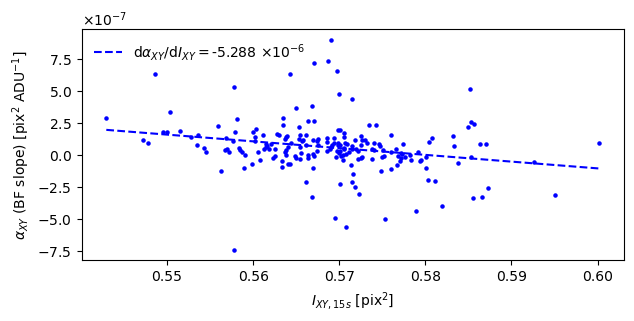

In [16]:
x = []
y = []
#x2 = []
#y2 = []
plt.figure(figsize=(7,3))
for count, key in enumerate(t):
    #print(t[key]['exptime'])
    inds = np.argwhere(np.asarray(t[key]['exptime']) == 20.0)
    if len(inds) == 0:
        continue
    if t[key]['slope-ixx']*100*10000 > 3.:
        continue
    
    x.append(np.mean(t[key]['Ixy'][inds]))
    y.append(t[key]['slope-ixy'])
    #x2.append(np.mean(t[key]['Iyy'][inds]))
    #y2.append(t[key]['slope-iyy'])
    #plt.scatter(np.mean(ref[key]['Iyy']),t[key]['slope-iyy'], s=5, color="b")
    plt.scatter(np.mean(ref[key]['Ixy']),t[key]['slope-ixy'], s=5, color="b")
    #plt.scatter(,t[key]['slope']*100*10000, color="b")

m,b = np.polyfit(x, y, 1)
#m2,b2 = np.polyfit(x2, y2, 1)
m_prime = str(round(m * 1e6, 3))
#m2_prime = str(round(m2 * 1e6, 3))
#plt.plot(np.linspace(np.min(x2), np.max(x2), 100), m2 * np.linspace(np.min(x2), np.max(x2), 100) + b2, linestyle="--", color='blue', label=r"$\mathrm{d}\alpha_{YY} / \mathrm{d}I_{YY} = $" + m2_prime + r" $\times 10^{-6}$")
plt.plot(np.linspace(np.min(x), np.max(x), 100), m * np.linspace(np.min(x), np.max(x), 100) + b, linestyle="--", color='blue', label=r"$\mathrm{d}\alpha_{XY} / \mathrm{d}I_{XY} = $" + m_prime + r" $\times 10^{-6}$")


plt.ylabel(r"$\alpha_{XY}$ (BF slope) [pix$^{2}$ e$^{-1}$]")
plt.xlabel(r"$I_{XY,15s}$ [pix$^2$]")
#plt.xlim(19.96, 20.13)
#plt.ylim(-1.0e-6,1.0e-6)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0), useMathText=True)
_ = plt.legend(loc=2, frameon=False)

# R24-S11
_____________________

## BF Uncorrected

In [19]:
# Use sensor data
sensor = "R03_S12"
detector = 23

# Butler repository
outdir = "/home/a/abrought/run5/BF/data/2023-01-26/"

# Retrieve data
data_corrected = readData( outdir + "data_13250_R24_S11_2023-02-23T16:19:20_680nm_ellipse_uncorrected_max100kE.pkl", \
                             expstoremove=1)
data_corrected = readData(   outdir + "data_13250_R24_S11_2023-02-23T15:47:17_680nm_ellipse_corrected_max100kE_noQuadFit_corrModelr_3.pkl", \
                             expstoremove=1)




Removing SEQNUMs: 
1051 858 1157 957 

File 1
10.0s, 28 images
15.0s, 39 images
20.0s, 40 images
25.0s, 38 images
30.0s, 39 images
35.0s, 39 images
40.0s, 38 images
45.0s, 39 images
50.0s, 40 images


 340
Removing SEQNUMs: 
1051 858 1157 957 

File 1
10.0s, 28 images
15.0s, 39 images
20.0s, 40 images
25.0s, 38 images
30.0s, 39 images
35.0s, 39 images
40.0s, 38 images
45.0s, 39 images
50.0s, 40 images


 340


In [20]:
t, ref, spots_to_track = plot_bf_slope_each_spot(data_uncorrected)

Num spots to track: 219


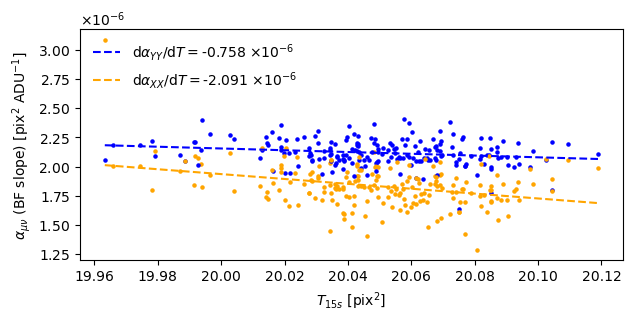

In [21]:
x = []
y = []
x2 = []
y2 = []
plt.figure(figsize=(7,3))
for count, key in enumerate(t):
    #print(t[key]['exptime'])
    inds = np.argwhere(np.asarray(t[key]['exptime']) == 20.0)
    if len(inds) == 0:
        continue
    #if t[key]['slope-ixx']*100*10000 > 1.:
    #    continue
    x.append(np.mean(t[key]['Ixx'][inds])+np.mean(t[key]['Iyy'][inds]))
    y.append(t[key]['slope-ixx'])
    x2.append(np.mean(t[key]['Ixx'][inds])+np.mean(t[key]['Iyy'][inds]))
    y2.append(t[key]['slope-iyy'])
    plt.scatter(np.mean(t[key]['Ixx'][inds])+np.mean(t[key]['Iyy'][inds]),t[key]['slope-iyy'], s=5, color="b")
    plt.scatter(np.mean(t[key]['Ixx'][inds])+np.mean(t[key]['Iyy'][inds]),t[key]['slope-ixx'], s=5, color="orange")
    #plt.scatter(,t[key]['slope']*100*10000, color="b")

m,b = np.polyfit(x, y, 1)
m2,b2 = np.polyfit(x2, y2, 1)
m_prime = str(round(m * 1e6, 3))
m2_prime = str(round(m2 * 1e6, 3))
plt.plot(np.linspace(np.min(x2), np.max(x2), 100), m2 * np.linspace(np.min(x2), np.max(x2), 100) + b2, linestyle="--", color='blue', label=r"$\mathrm{d}\alpha_{YY} / \mathrm{d}T = $" + m2_prime + r" $\times 10^{-6}$")
plt.plot(np.linspace(np.min(x), np.max(x), 100), m * np.linspace(np.min(x), np.max(x), 100) + b, linestyle="--", color='orange', label=r"$\mathrm{d}\alpha_{XX} / \mathrm{d}T = $" + m_prime + r" $\times 10^{-6}$")


plt.ylabel(r"$\alpha_{\mu\nu}$ (BF slope) [pix$^{2}$ e$^{-1}$]")
plt.xlabel("$T_{15s}$ [pix$^2$]")
#plt.xlim(19.96, 20.13)
#plt.ylim(-0.5e-6,2.1e-6)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0), useMathText=True)
_ = plt.legend(loc=2, frameon=False)

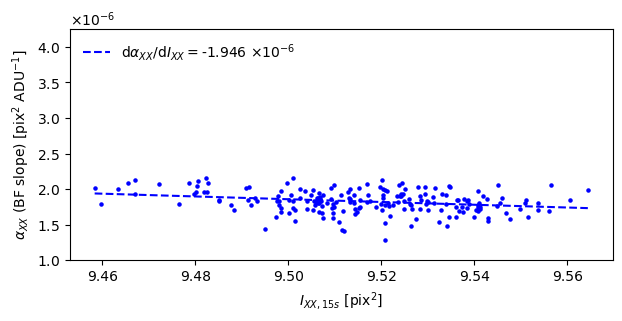

In [22]:
x = []
y = []
#x2 = []
#y2 = []
plt.figure(figsize=(7,3))
for count, key in enumerate(t):
    #print(t[key]['exptime'])
    inds = np.argwhere(np.asarray(t[key]['exptime']) == 20.0)
    if len(inds) == 0:
        continue
    if t[key]['slope-ixx']*100*10000 > 3.:
        continue
    
    x.append(np.mean(t[key]['Ixx'][inds]))
    y.append(t[key]['slope-ixx'])
    #x2.append(np.mean(t[key]['Iyy'][inds]))
    #y2.append(t[key]['slope-iyy'])
    #plt.scatter(np.mean(ref[key]['Iyy']),t[key]['slope-iyy'], s=5, color="b")
    plt.scatter(np.mean(ref[key]['Ixx']),t[key]['slope-ixx'], s=5, color="b")
    #plt.scatter(,t[key]['slope']*100*10000, color="b")

m,b = np.polyfit(x, y, 1)
#m2,b2 = np.polyfit(x2, y2, 1)
m_prime = str(round(m * 1e6, 3))
#m2_prime = str(round(m2 * 1e6, 3))
#plt.plot(np.linspace(np.min(x2), np.max(x2), 100), m2 * np.linspace(np.min(x2), np.max(x2), 100) + b2, linestyle="--", color='blue', label=r"$\mathrm{d}\alpha_{YY} / \mathrm{d}I_{YY} = $" + m2_prime + r" $\times 10^{-6}$")
plt.plot(np.linspace(np.min(x), np.max(x), 100), m * np.linspace(np.min(x), np.max(x), 100) + b, linestyle="--", color='blue', label=r"$\mathrm{d}\alpha_{XX} / \mathrm{d}I_{XX} = $" + m_prime + r" $\times 10^{-6}$")


plt.ylabel(r"$\alpha_{XX}$ (BF slope) [pix$^{2}$ e$^{-1}$]")
plt.xlabel(r"$I_{XX,15s}$ [pix$^2$]")
#plt.xlim(19.96, 20.13)
plt.ylim(1.0e-6,4.25e-6)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0), useMathText=True)
_ = plt.legend(loc=2, frameon=False)

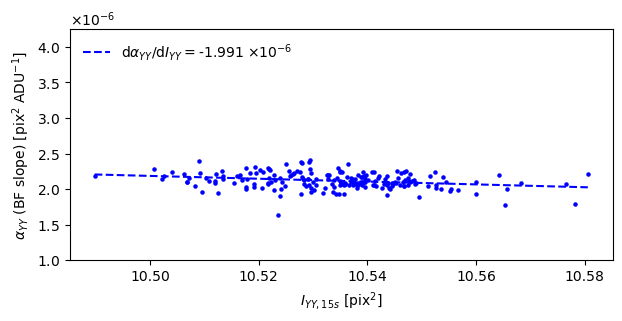

In [23]:
#x = []
#y = []
x2 = []
y2 = []
plt.figure(figsize=(7,3))
for count, key in enumerate(t):
    #print(t[key]['exptime'])
    inds = np.argwhere(np.asarray(t[key]['exptime']) == 20.0)
    if len(inds) == 0:
        continue
    if t[key]['slope-ixx']*100*10000 > 3.:
        continue
    
    #x.append(np.mean(t[key]['Ixx'][inds]))
    #y.append(t[key]['slope-ixx'])
    x2.append(np.mean(t[key]['Iyy'][inds]))
    y2.append(t[key]['slope-iyy'])
    plt.scatter(np.mean(ref[key]['Iyy']),t[key]['slope-iyy'], s=5, color="b")
    #plt.scatter(np.mean(ref[key]['Ixx']),t[key]['slope-ixx'], s=5, color="b")
    #plt.scatter(,t[key]['slope']*100*10000, color="b")

#m,b = np.polyfit(x, y, 1)
m2,b2 = np.polyfit(x2, y2, 1)
#m_prime = str(round(m * 1e6, 3))
m2_prime = str(round(m2 * 1e6, 3))
plt.plot(np.linspace(np.min(x2), np.max(x2), 100), m2 * np.linspace(np.min(x2), np.max(x2), 100) + b2, linestyle="--", color='blue', label=r"$\mathrm{d}\alpha_{YY} / \mathrm{d}I_{YY} = $" + m2_prime + r" $\times 10^{-6}$")
#plt.plot(np.linspace(np.min(x), np.max(x), 100), m * np.linspace(np.min(x), np.max(x), 100) + b, linestyle="--", color='blue', label=r"$\mathrm{d}\alpha_{XX} / \mathrm{d}I_{XX} = $" + m_prime + r" $\times 10^{-6}$")


plt.ylabel(r"$\alpha_{YY}$ (BF slope) [pix$^{2}$ e$^{-1}$]")
plt.xlabel(r"$I_{YY,15s}$ [pix$^2$]")
#plt.xlim(19.96, 20.13)
plt.ylim(1.0e-6,4.25e-6)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0), useMathText=True)
_ = plt.legend(loc=2, frameon=False)

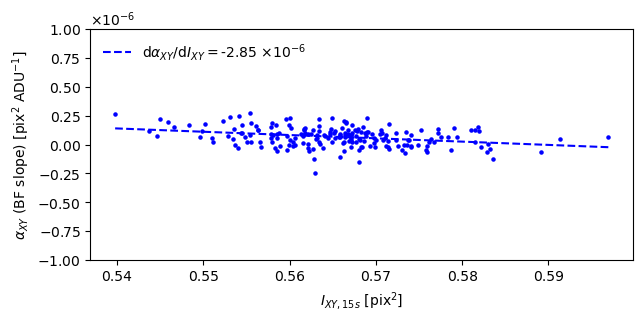

In [24]:
x = []
y = []
#x2 = []
#y2 = []
plt.figure(figsize=(7,3))
for count, key in enumerate(t):
    #print(t[key]['exptime'])
    inds = np.argwhere(np.asarray(t[key]['exptime']) == 20.0)
    if len(inds) == 0:
        continue
    if t[key]['slope-ixx']*100*10000 > 3.:
        continue
    
    x.append(np.mean(t[key]['Ixy'][inds]))
    y.append(t[key]['slope-ixy'])
    #x2.append(np.mean(t[key]['Iyy'][inds]))
    #y2.append(t[key]['slope-iyy'])
    #plt.scatter(np.mean(ref[key]['Iyy']),t[key]['slope-iyy'], s=5, color="b")
    plt.scatter(np.mean(ref[key]['Ixy']),t[key]['slope-ixy'], s=5, color="b")
    #plt.scatter(,t[key]['slope']*100*10000, color="b")

m,b = np.polyfit(x, y, 1)
#m2,b2 = np.polyfit(x2, y2, 1)
m_prime = str(round(m * 1e6, 3))
#m2_prime = str(round(m2 * 1e6, 3))
#plt.plot(np.linspace(np.min(x2), np.max(x2), 100), m2 * np.linspace(np.min(x2), np.max(x2), 100) + b2, linestyle="--", color='blue', label=r"$\mathrm{d}\alpha_{YY} / \mathrm{d}I_{YY} = $" + m2_prime + r" $\times 10^{-6}$")
plt.plot(np.linspace(np.min(x), np.max(x), 100), m * np.linspace(np.min(x), np.max(x), 100) + b, linestyle="--", color='blue', label=r"$\mathrm{d}\alpha_{XY} / \mathrm{d}I_{XY} = $" + m_prime + r" $\times 10^{-6}$")


plt.ylabel(r"$\alpha_{XY}$ (BF slope) [pix$^{2}$ e$^{-1}$]")
plt.xlabel(r"$I_{XY,15s}$ [pix$^2$]")
#plt.xlim(19.96, 20.13)
plt.ylim(-1.0e-6,1.0e-6)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0), useMathText=True)
_ = plt.legend(loc=2, frameon=False)

## BF Corrected

In [25]:
t, ref, spots_to_track = plot_bf_slope_each_spot(data_corrected)

Num spots to track: 957


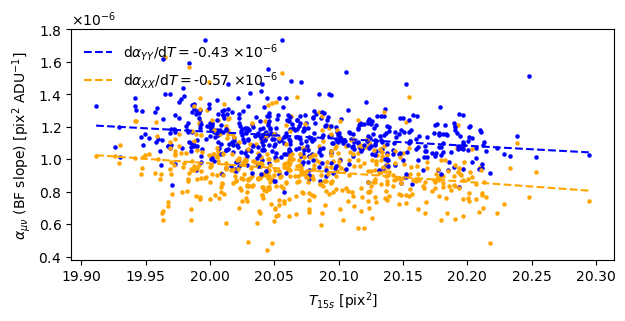

In [26]:
x = []
y = []
x2 = []
y2 = []
plt.figure(figsize=(7,3))
for count, key in enumerate(t):
    #print(t[key]['exptime'])
    inds = np.argwhere(np.asarray(t[key]['exptime']) == 20.0)
    if len(inds) == 0:
        continue
    if t[key]['slope-ixx']*100*10000 > 2. or t[key]['slope-ixx']*100*10000 < 0. or t[key]['slope-iyy']*100*10000 > 2. or t[key]['slope-iyy']*100*10000 < 0.:
        continue
    if np.mean(t[key]['Ixx'][inds])+np.mean(t[key]['Iyy'][inds]) > 20.4:
        continue
    x.append(np.mean(t[key]['Ixx'][inds])+np.mean(t[key]['Iyy'][inds]))
    y.append(t[key]['slope-ixx'])
    x2.append(np.mean(t[key]['Ixx'][inds])+np.mean(t[key]['Iyy'][inds]))
    y2.append(t[key]['slope-iyy'])
    plt.scatter(np.mean(t[key]['Ixx'][inds])+np.mean(t[key]['Iyy'][inds]),t[key]['slope-iyy'], s=5, color="b")
    plt.scatter(np.mean(t[key]['Ixx'][inds])+np.mean(t[key]['Iyy'][inds]),t[key]['slope-ixx'], s=5, color="orange")
    #plt.scatter(,t[key]['slope']*100*10000, color="b")

m,b = np.polyfit(x, y, 1)
m2,b2 = np.polyfit(x2, y2, 1)
m_prime = str(round(m * 1e6, 3))
m2_prime = str(round(m2 * 1e6, 3))
plt.plot(np.linspace(np.min(x2), np.max(x2), 100), m2 * np.linspace(np.min(x2), np.max(x2), 100) + b2, linestyle="--", color='blue', label=r"$\mathrm{d}\alpha_{YY} / \mathrm{d}T = $" + m2_prime + r" $\times 10^{-6}$")
plt.plot(np.linspace(np.min(x), np.max(x), 100), m * np.linspace(np.min(x), np.max(x), 100) + b, linestyle="--", color='orange', label=r"$\mathrm{d}\alpha_{XX} / \mathrm{d}T = $" + m_prime + r" $\times 10^{-6}$")


plt.ylabel(r"$\alpha_{\mu\nu}$ (BF slope) [pix$^{2}$ e$^{-1}$]")
plt.xlabel("$T_{15s}$ [pix$^2$]")
#plt.xlim(19.96, 20.13)
#plt.ylim(-0.5e-6,2.1e-6)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0), useMathText=True)
_ = plt.legend(loc=2, frameon=False)

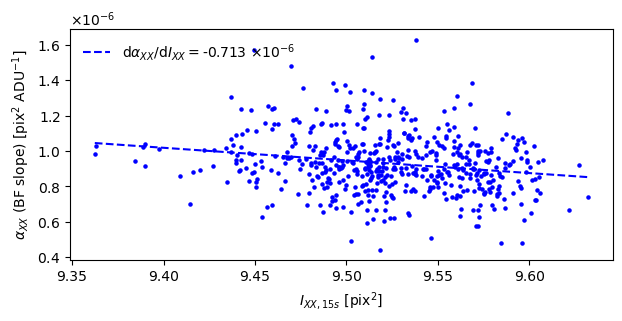

In [27]:
x = []
y = []
#x2 = []
#y2 = []
plt.figure(figsize=(7,3))
for count, key in enumerate(t):
    #print(t[key]['exptime'])
    inds = np.argwhere(np.asarray(t[key]['exptime']) == 20.0)
    if len(inds) == 0:
        continue
    if t[key]['slope-ixx']*100*10000 > 2.:
        continue
    
    x.append(np.mean(t[key]['Ixx'][inds]))
    y.append(t[key]['slope-ixx'])
    #x2.append(np.mean(t[key]['Iyy'][inds]))
    #y2.append(t[key]['slope-iyy'])
    #plt.scatter(np.mean(ref[key]['Iyy']),t[key]['slope-iyy'], s=5, color="b")
    plt.scatter(np.mean(ref[key]['Ixx']),t[key]['slope-ixx'], s=5, color="b")
    #plt.scatter(,t[key]['slope']*100*10000, color="b")

m,b = np.polyfit(x, y, 1)
#m2,b2 = np.polyfit(x2, y2, 1)
m_prime = str(round(m * 1e6, 3))
#m2_prime = str(round(m2 * 1e6, 3))
#plt.plot(np.linspace(np.min(x2), np.max(x2), 100), m2 * np.linspace(np.min(x2), np.max(x2), 100) + b2, linestyle="--", color='blue', label=r"$\mathrm{d}\alpha_{YY} / \mathrm{d}I_{YY} = $" + m2_prime + r" $\times 10^{-6}$")
plt.plot(np.linspace(np.min(x), np.max(x), 100), m * np.linspace(np.min(x), np.max(x), 100) + b, linestyle="--", color='blue', label=r"$\mathrm{d}\alpha_{XX} / \mathrm{d}I_{XX} = $" + m_prime + r" $\times 10^{-6}$")


plt.ylabel(r"$\alpha_{XX}$ (BF slope) [pix$^{2}$ e$^{-1}$]")
plt.xlabel(r"$I_{XX,15s}$ [pix$^2$]")
#plt.xlim(19.96, 20.13)
#plt.ylim(1.0e-6,4.25e-6)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0), useMathText=True)
_ = plt.legend(loc=2, frameon=False)

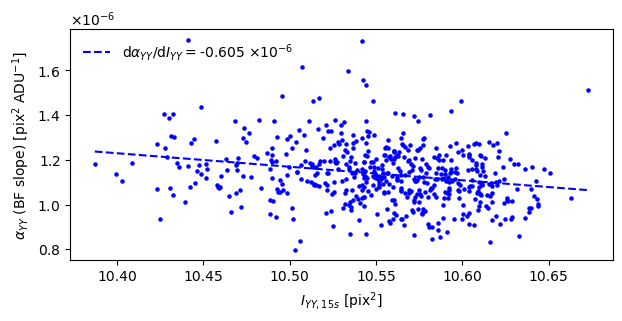

In [28]:
#x = []
#y = []
x2 = []
y2 = []
plt.figure(figsize=(7,3))
for count, key in enumerate(t):
    #print(t[key]['exptime'])
    inds = np.argwhere(np.asarray(t[key]['exptime']) == 20.0)
    if len(inds) == 0:
        continue
    if t[key]['slope-iyy']*100*10000 > 2. or t[key]['slope-iyy']*100*10000 < 0.:
        continue
    
    #x.append(np.mean(t[key]['Ixx'][inds]))
    #y.append(t[key]['slope-ixx'])
    x2.append(np.mean(t[key]['Iyy'][inds]))
    y2.append(t[key]['slope-iyy'])
    plt.scatter(np.mean(ref[key]['Iyy']),t[key]['slope-iyy'], s=5, color="b")
    #plt.scatter(np.mean(ref[key]['Ixx']),t[key]['slope-ixx'], s=5, color="b")
    #plt.scatter(,t[key]['slope']*100*10000, color="b")

#m,b = np.polyfit(x, y, 1)
m2,b2 = np.polyfit(x2, y2, 1)
#m_prime = str(round(m * 1e6, 3))
m2_prime = str(round(m2 * 1e6, 3))
plt.plot(np.linspace(np.min(x2), np.max(x2), 100), m2 * np.linspace(np.min(x2), np.max(x2), 100) + b2, linestyle="--", color='blue', label=r"$\mathrm{d}\alpha_{YY} / \mathrm{d}I_{YY} = $" + m2_prime + r" $\times 10^{-6}$")
#plt.plot(np.linspace(np.min(x), np.max(x), 100), m * np.linspace(np.min(x), np.max(x), 100) + b, linestyle="--", color='blue', label=r"$\mathrm{d}\alpha_{XX} / \mathrm{d}I_{XX} = $" + m_prime + r" $\times 10^{-6}$")


plt.ylabel(r"$\alpha_{YY}$ (BF slope) [pix$^{2}$ e$^{-1}$]")
plt.xlabel(r"$I_{YY,15s}$ [pix$^2$]")
#plt.xlim(19.96, 20.13)
#plt.ylim(1.0e-6,4.25e-6)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0), useMathText=True)
_ = plt.legend(loc=2, frameon=False)

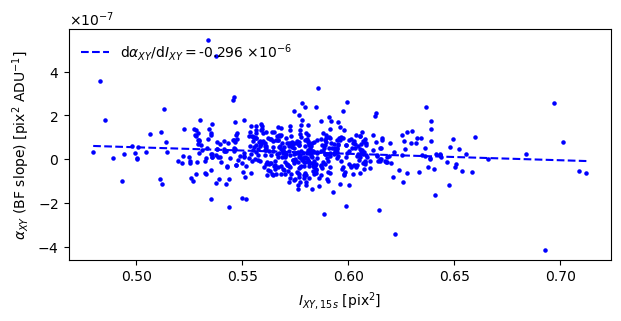

In [29]:
x = []
y = []
#x2 = []
#y2 = []
plt.figure(figsize=(7,3))
for count, key in enumerate(t):
    #print(t[key]['exptime'])
    inds = np.argwhere(np.asarray(t[key]['exptime']) == 20.0)
    if len(inds) == 0:
        continue
    #if t[key]['slope-ixx']*100*10000 > 3.:
    #    continue
    
    x.append(np.mean(t[key]['Ixy'][inds]))
    y.append(t[key]['slope-ixy'])
    #x2.append(np.mean(t[key]['Iyy'][inds]))
    #y2.append(t[key]['slope-iyy'])
    #plt.scatter(np.mean(ref[key]['Iyy']),t[key]['slope-iyy'], s=5, color="b")
    plt.scatter(np.mean(ref[key]['Ixy']),t[key]['slope-ixy'], s=5, color="b")
    #plt.scatter(,t[key]['slope']*100*10000, color="b")

m,b = np.polyfit(x, y, 1)
#m2,b2 = np.polyfit(x2, y2, 1)
m_prime = str(round(m * 1e6, 3))
#m2_prime = str(round(m2 * 1e6, 3))
#plt.plot(np.linspace(np.min(x2), np.max(x2), 100), m2 * np.linspace(np.min(x2), np.max(x2), 100) + b2, linestyle="--", color='blue', label=r"$\mathrm{d}\alpha_{YY} / \mathrm{d}I_{YY} = $" + m2_prime + r" $\times 10^{-6}$")
plt.plot(np.linspace(np.min(x), np.max(x), 100), m * np.linspace(np.min(x), np.max(x), 100) + b, linestyle="--", color='blue', label=r"$\mathrm{d}\alpha_{XY} / \mathrm{d}I_{XY} = $" + m_prime + r" $\times 10^{-6}$")


plt.ylabel(r"$\alpha_{XY}$ (BF slope) [pix$^{2}$ e$^{-1}$]")
plt.xlabel(r"$I_{XY,15s}$ [pix$^2$]")
#plt.xlim(19.96, 20.13)
#plt.ylim(-1.0e-6,1.0e-6)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0), useMathText=True)
_ = plt.legend(loc=2, frameon=False)